# ESTIMATION OF ANNUAL INSURANCE CHARGES

#PROBLEM STATEMENT

> ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States.**I need to create an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 



# 1. DATA ACQUISITION

# **Dataset source**
[Data Set](https://github.com/stedy/Machine-Learning-with-R-datasets)

In [1]:
import pandas as pd

In [2]:
data =  pd.read_csv('medical.csv')
medical_df = data.copy()

In [3]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns.

In [4]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 57.6+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values.

## Here are some statistics for the numerical columns:

In [5]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!). The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.




# 2. DATA EXPLORATION

In [6]:
!pip install plotly matplotlib seaborn --quiet

In [7]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following settings will improve the default style and font sizes for our charts.

In [8]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. 

In [9]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [10]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.




### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [11]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['green'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)



### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [12]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['red', 'green'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \$7300, the median for smokers is close to \$35,000.


### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [13]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [14]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

It appears that 20% of customers have reported that they smoke. We can also see that smoking appears a more common habit among males



# Visualizing the relationship between **"charges"** and other columns.

## Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. Use values in the "smoker" column to color the points.

In [15]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     


### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Use the values from the "smoker" column to color the points.

In [16]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.


## Correlation

- As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

- Let see the correlation between each feature.




Here's how correlation coefficients can be interpreted ([source](https://statisticsbyjim.com/basics/correlations)):

* **Strength**: The greater the absolute value of the correlation coefficient, the stronger the relationship.

    * The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

    * A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.
    
    * When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.


* **Direction**: The sign of the correlation coefficient represents the direction of the relationship.

    * Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.
    
    * Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Here's the same relationship expressed visually ([source](https://www.cuemath.com/data/how-to-calculate-correlation-coefficient/)):

<img src="https://i.imgur.com/3XUpDlw.png" width="360">

The correlation coefficient has the following formula:

<img src="https://i.imgur.com/unapugP.png" width="360">

Pandas dataframes also provide a `.corr` method to compute the correlation coefficients between all pairs of numeric columns.

In [17]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


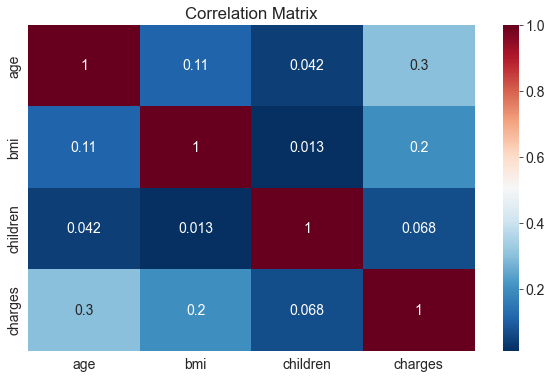

In [18]:
sns.heatmap(medical_df.corr(), cmap='RdBu_r', annot=True)
plt.title('Correlation Matrix');

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 

While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated system can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.

# 3. DATA PREPARATION

### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

* Calculate the difference between the targets and predictions (the differenced is called the "residual")
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.
* Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE). The above description can be stated mathematically as follows: 

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Geometrically, the residuals can be visualized as follows:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Let's define a function to compute the RMSE.

In [19]:
!pip install numpy --quiet

In [20]:
import numpy as np

In [21]:
!pip install scikit-learn --quiet

## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals




## Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".


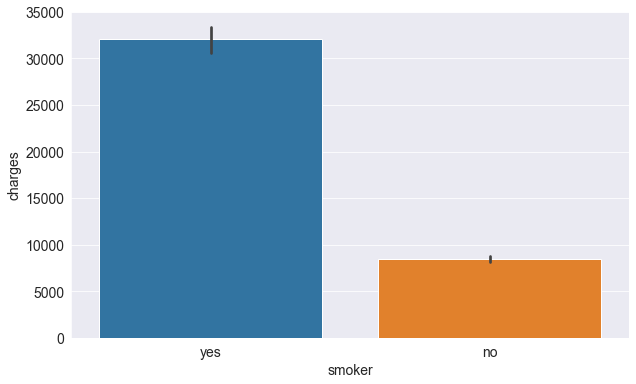

In [22]:
sns.barplot(data=medical_df, x='smoker', y='charges');

In [23]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [24]:
medical_df.charges.corr(medical_df.smoker_code)

0.7872514304984765

In [25]:
medical_df.head()


,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


<AxesSubplot:xlabel='sex', ylabel='charges'>

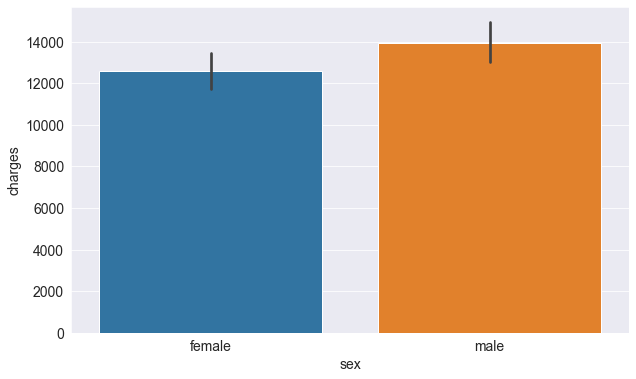

In [26]:
sns.barplot(data=medical_df, x='sex', y='charges')

In [27]:
sex_codes = {'female': 0, 'male': 1}

In [28]:
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [29]:
medical_df.charges.corr(medical_df.sex_code)

0.05729206220202531

As you might expect, this does have a significant impact on the loss.


### One-hot Encoding

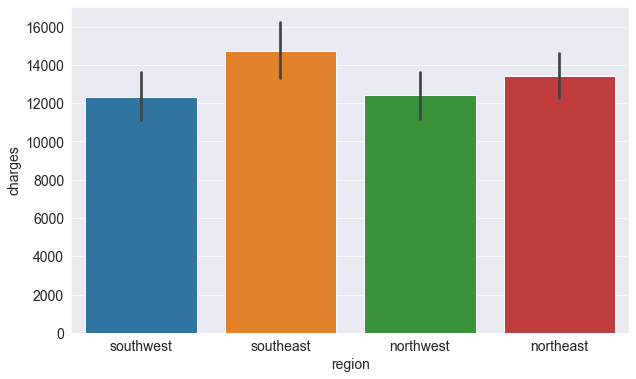

In [30]:
sns.barplot(data=medical_df, x='region', y='charges');

In [31]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [32]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [33]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [34]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


<AxesSubplot:>

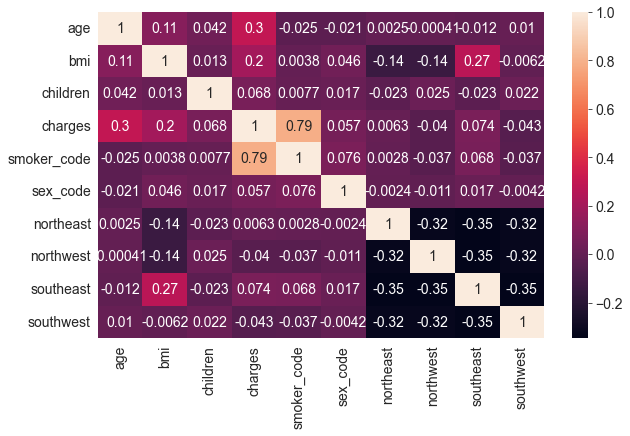

In [43]:
sns.heatmap(medical_df.corr(), annot=True)


## Feature Scaling



The most important feature are:

1. Smoker
2. Age
3. BMI


In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# EXTRACTING THE FEATURES THATS REQUIRED FOR THE MODEL

In [57]:
input_data = medical_df[['age','bmi' , 'children','smoker_code','sex_code' ,'northeast' ,'northwest' ,'southeast' ,'southwest']]
input_data.values

array([[19.  , 27.9 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       [18.  , 33.77,  1.  , ...,  0.  ,  1.  ,  0.  ],
       [28.  , 33.  ,  3.  , ...,  0.  ,  1.  ,  0.  ],
       ...,
       [18.  , 36.85,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [21.  , 25.8 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       [61.  , 29.07,  0.  , ...,  1.  ,  0.  ,  0.  ]])

In [60]:
output_data = medical_df['charges']
output_data.values

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

# 4.  MODELS TRAINING AND TESTING 

## Creating a Test Set


In [61]:
from sklearn.model_selection import train_test_split

In [62]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(input_data, output_data, test_size=0.2)

In [72]:
print(len(inputs_train))
len(targets_test)

1070


268

In [98]:
pip install tensorflow --quiet

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


# 5.  FINE TUNING

# 6. SAVING THE MODEL

# 7.  CONCLUSION